<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_data_model.pickle") # read pickle file
labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive


In [3]:
# Subsample the data and features
Hz_chest = 700
Hz_EDA = 4
subsample_rate = int(Hz_chest / Hz_EDA)  # subsample rate, e.g. to reduce from 700Hz to 4Hz

subsampled_data = data[::subsample_rate]
subsampled_labels = labels[::subsample_rate]

print(len(data))  # 2742499
print(len(subsampled_data))  # 15672

2742499
15672


In [4]:
# Check for NaN values
subsampled_data.isnull().values.any()

False

In [5]:
# Try with a Datagenerator to reduce the RAM use
from keras.preprocessing.sequence import TimeseriesGenerator
random_state = 42
sampling_rate = 5 # keep one data point out of 5
duration = 1 # how many minutes in the future the target after the end of the sequence
sequence_length = Hz_EDA * 60 * duration # observations will go back duration minutues
delay = sampling_rate*(sequence_length + duration*60*Hz_EDA - 1) # the target for a
                                                             # sequence will be
                                                             # duration (min)
                                                             # after the end of
                                                             # the sequence
batch_size = 64
shuffle = True

# Train Test Split
from sklearn.model_selection import train_test_split

X_dat, X_val, y_dat, y_val = train_test_split(subsampled_data, subsampled_labels, 
                                                 test_size = 0.2,
                                                 random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X_dat, y_dat,
                                                    test_size = 0.2,
                                                    random_state = random_state)


# Normalize the data
from sklearn.preprocessing import StandardScaler
# create the StandardScaler object
scaler = StandardScaler()
# fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1,1))
# transform the validation data
X_val_scaled = scaler.transform(X_val.values.reshape(-1,1))
# transform the test data
X_test_scaled = scaler.transform(X_test.values.reshape(-1,1))

# Data Generator
train_data_gen = TimeseriesGenerator(X_train_scaled, y_train, length=sequence_length, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val_scaled, y_val, length=sequence_length, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test_scaled, y_test, length=sequence_length, batch_size=batch_size)

In [6]:
print(train_data_gen[0][0].shape) # prints the batch size of the first entry
'''
A tensor of shape (32, 1200, 1) means that it is a 3-dimensional tensor with 32 
rows, 240 columns and 1 channel. In this specific case, it could represent a 
batch of 32 time series samples, each with 1200 time steps and 1 feature/channel.

The first dimension (32) represents the batch size, which is the number of 
samples that are processed at once during training. The second dimension (1200) 
represents the time steps or the sequence length of each sample, and the third 
dimension (1) represents the number of features or channels in each sample.
'''

(64, 240, 1)


'\nA tensor of shape (32, 1200, 1) means that it is a 3-dimensional tensor with 32 \nrows, 240 columns and 1 channel. In this specific case, it could represent a \nbatch of 32 time series samples, each with 1200 time steps and 1 feature/channel.\n\nThe first dimension (32) represents the batch size, which is the number of \nsamples that are processed at once during training. The second dimension (1200) \nrepresents the time steps or the sequence length of each sample, and the third \ndimension (1) represents the number of features or channels in each sample.\n'

In [7]:
train_iterator = iter(train_data_gen)
x_batch, y_batch = next(train_iterator)
print(x_batch.shape)
print(y_batch.shape)

# Validation Data
val_iterator = iter(val_data_gen)
x_batch, y_batch = next(val_iterator)
print(x_batch.shape)
print(y_batch.shape)

(64, 240, 1)
(64,)
(64, 240, 1)
(64,)


In [7]:
# Naive Model
def evaluate_naive_method(dataset):
  '''
  This method uses a common-sense approach to predict that the subject will be
  in the same state 5 minutes from now as they are in now.
  '''
  

In [8]:
type(train_data_gen[0][0].shape[2])
print(sequence_length)

240


In [63]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

In [64]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    # Import libraries
    import matplotlib.pyplot as plt
    
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

In [77]:
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
  '''
  What does this function do?
  val_data: validation data generator
  test_data: testing data generator
  '''
  # Evaluate the model
  from tensorflow.keras.models import load_model
  import joblib

  # Load the model
  model = load_model(model_filepath)
  model_eval_val = model.evaluate(val_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  
  # Load the training fit history
  fit_history = joblib.load(history_filepath) # read pickle file

  # Make Plot of Training Fit
  plot_evaluation(fit_history, save_plot_path)

  # Print validation and testing metrics
  print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
  model_eval_test = model.evaluate(test_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
  return model, fit_history

In [69]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
x = Flatten()(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs)

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 240, 1)]          0         
                                                                 
 flatten_8 (Flatten)         (None, 240)               0         
                                                                 
 dense_25 (Dense)            (None, 16)                3856      
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [72]:
# Fit the model to the training data
history_0 = model_0.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_0_filepath,
                                            patience=10))

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
153/153 [==============================] - 1s 4ms/step - loss: 2.1485 - binary_accuracy: 0.8065 - val_loss: 2.5053 - val_binary_accuracy: 0.7914
Epoch 2/200
153/153 [==============================] - 1s 4ms/step - loss: 2.0754 - binary_accuracy: 0.8121 - val_loss: 2.5026 - val_binary_accuracy: 0.7876
Epoch 3/200
153/153 [==============================] - 1s 4ms/step - loss: 2.0540 - binary_accuracy: 0.8161 - val_loss: 2.3952 - val_binary_accuracy: 0.7772
Epoch 4/200
153/153 [==============================] - 1s 4ms/step - loss: 1.9825 - binary_accuracy: 0.8221 - val_loss: 2.4086 - val_binary_accuracy: 0.7831
Epoch 5/200
153/153 [==============================] - 1s 4ms/step - loss: 1.9657 - binary_accuracy: 0.8203 - val_loss: 2.4267 - val_binary_accuracy: 0.7831
Epoch 6/200
153/153 [==============================] - 1s 4ms/step - loss: 1.9280 - binary_accuracy: 0.8285 - val_loss: 2.4313 - val_binary_accuracy: 0.7796
Epoch 7/200
153/153 [==============================] - 1s 

46/46 [==============================] - 0s 6ms/step - loss: 2.4729 - binary_accuracy: 0.7796
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-24 14:21:24           64
variables.h5                                   2023-03-24 14:21:24        53992
config.json                                    2023-03-24 14:21:24         2283
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
...vars


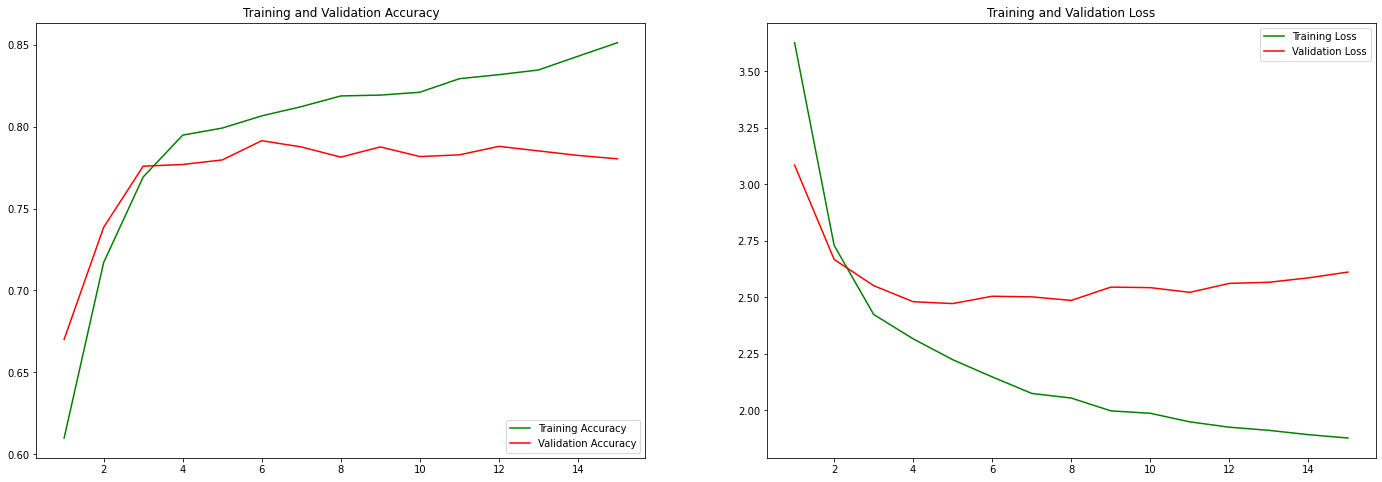

Validation Binary Accuracy is: 0.78
36/36 [==============================] - 0s 7ms/step - loss: 2.5145 - binary_accuracy: 0.7646
Testing Binary Accuracy is: 0.76


In [71]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_data_gen, 
                         test_data_gen,
                         'models/evaluate/model_0_evaluation.pdf')

In [74]:
'''
Model_1: Simple LSTM Model
Timeseries data is a sequence, where causality and sequence matter.
'''
from keras.callbacks import EarlyStopping, ModelCheckpoint

inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
x = LSTM(batch_size, activation='relu', input_shape=(sequence_length, 1))(inputs)
outputs = layers.Dense(1, activation='sigmoid')(x)          
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['binary_accuracy'])


In [75]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [78]:
# Fit the model to the training data
history_1 = model_1.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_1_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

Epoch 1/200
153/153 [==============================] - 46s 301ms/step - loss: 798005788672.0000 - binary_accuracy: 0.8142 - val_loss: 0.4876 - val_binary_accuracy: 0.8138
Epoch 2/200
153/153 [==============================] - 46s 299ms/step - loss: 0.4864 - binary_accuracy: 0.8142 - val_loss: 0.4868 - val_binary_accuracy: 0.8138
Epoch 3/200
153/153 [==============================] - 46s 301ms/step - loss: 0.4858 - binary_accuracy: 0.8142 - val_loss: 0.4862 - val_binary_accuracy: 0.8138
Epoch 4/200
153/153 [==============================] - 46s 300ms/step - loss: 0.4852 - binary_accuracy: 0.8142 - val_loss: 0.4856 - val_binary_accuracy: 0.8138
Epoch 5/200
153/153 [==============================] - 46s 298ms/step - loss: 0.4847 - binary_accuracy: 0.8142 - val_loss: 0.4847 - val_binary_accuracy: 0.8138
Epoch 6/200
153/153 [==============================] - 46s 300ms/step - loss: 53099646976.0000 - binary_accuracy: 0.8142 - val_loss: 0.4834 - val_binary_accuracy: 0.8138
Epoch 7/200
153/153

46/46 [==============================] - 2s 34ms/step - loss: 0.4812 - binary_accuracy: 0.8138
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-24 14:45:50           64
variables.h5                                   2023-03-24 14:45:50       159224
config.json                                    2023-03-24 14:45:50         2588


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
...vars


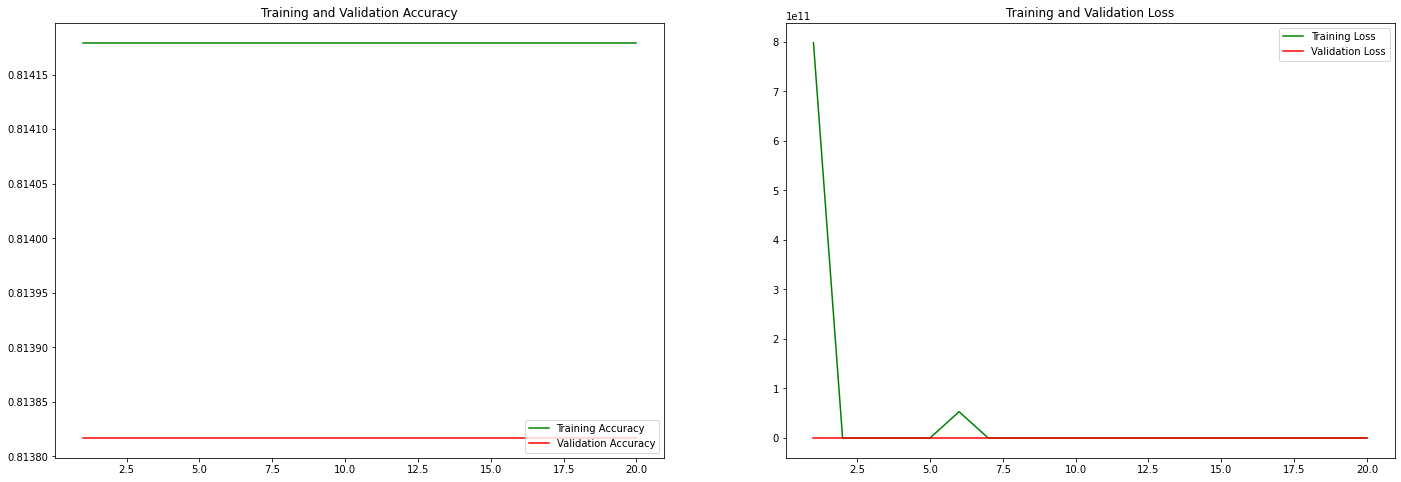

Validation Binary Accuracy is: 0.81
36/36 [==============================] - 1s 34ms/step - loss: 0.4879 - binary_accuracy: 0.8100
Testing Binary Accuracy is: 0.81


In [79]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_data_gen, 
                         test_data_gen,
                         'models/evaluate/model_0_evaluation.pdf')

Binary_accuracy and validation loss is stalling out around epoch 6-8. 

In [112]:
'''
Model 2: Complex LSTM with Dropout
'''
from keras.layers import LSTM, Dense, Dropout, Reshape, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam

# Build the model
inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))

# LSTM layer
x = LSTM(batch_size, 
         activation='relu', 
         input_shape=(sequence_length, 1),
         return_sequences = True,
         unroll=True,
         recurrent_dropout=0.5)(inputs) # Dropout
#x = Dense(units=batch_size//2, activation='relu')(x)

# Reshape the output of the last dense layer to match the desired shape
#x = Reshape((batch_size, 1))(x)

# Repeat the output across the sequence_length dimension
#x = RepeatVector((sequence_length))(x)

# Second LSTM Layer
x = LSTM(batch_size//2, 
         activation='relu', 
         return_sequences = True,
         unroll=True,
         recurrent_dropout=0.5)(x) # Dropout
x = TimeDistributed(Dense(1, activation='sigmoid'))(x)
outputs = Flatten()(x)

model_2 = keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['binary_accuracy'])

model_2.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 240, 1)]          0         
                                                                 
 lstm_39 (LSTM)              (None, 240, 64)           16896     
                                                                 
 lstm_40 (LSTM)              (None, 240, 32)           12416     
                                                                 
 time_distributed_1 (TimeDis  (None, 240, 1)           33        
 tributed)                                                       
                                                                 
 flatten_9 (Flatten)         (None, 240)               0         
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
______________________________________________________

In [113]:
# Parameters for fitting and saving model training data
epochs = 200
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'

In [ ]:
# Fit the model to the training data
history_2 = model_2.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_2_filepath,
                                            patience=3))

# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

Epoch 1/200


In [ ]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_data_gen, 
                         test_data_gen,
                         'models/evaluate/model_2_evaluation.pdf')

In [88]:
''''
Model 3: Bidirectional LSTM
'''

# Define the LSTM model
inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
# Next model add a Dense layer here
x = Dense(units=batch_size, activation='relu')(inputs)
x = layers.Bidirectional(LSTM(batch_size, 
                          activation='relu', 
                          input_shape=(sequence_length, 1),
                          unroll=True,
                          recurrent_dropout=0.5))(x)
x = Dense(units=batch_size//2, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_3 = keras.Model(inputs, outputs)

# Compile
model_3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.00001), 
              metrics=['binary_accuracy'])
model_3.summary()

In [89]:
# Parameters for fitting and saving model training data
epochs = 200
model_3_filepath = 'models/model_3_bidirLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_bidirLSTM_history.pkl'

Epoch 1/50
153/153 [==============================] - 351s 607ms/step - loss: 0.6978 - binary_accuracy: 0.4295 - val_loss: 0.6780 - val_binary_accuracy: 0.8066
Epoch 2/50
153/153 [==============================] - 63s 411ms/step - loss: 0.6562 - binary_accuracy: 0.8123 - val_loss: 0.6374 - val_binary_accuracy: 0.8138
Epoch 3/50
153/153 [==============================] - 63s 412ms/step - loss: 0.7278 - binary_accuracy: 0.8142 - val_loss: 0.5990 - val_binary_accuracy: 0.8138
Epoch 4/50
153/153 [==============================] - 63s 413ms/step - loss: 590928.1250 - binary_accuracy: 0.8142 - val_loss: 0.5789 - val_binary_accuracy: 0.8138
Epoch 5/50
153/153 [==============================] - 63s 413ms/step - loss: 114.6105 - binary_accuracy: 0.8140 - val_loss: 0.5736 - val_binary_accuracy: 0.8138
Epoch 6/50
153/153 [==============================] - 63s 412ms/step - loss: 429775872.0000 - binary_accuracy: 0.8142 - val_loss: 0.5698 - val_binary_accuracy: 0.8138
Epoch 7/50
153/153 [==========

In [43]:
# Fit the model to the training data
history_3 = model_3.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_3_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

NameError: ignored

In [ ]:

# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_0_filepath, 
                         history_3_filepath,
                         val_data_gen, 
                         test_data_gen,
                         'models/evaluate/model_3_evaluation.pdf')

In [26]:
'''
Model_4: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(sequence_length, train_data_gen[0][0].shape[2]))
    #inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Build model
model_4 = build_transformer_model(
                sequence_length,
                n_classes=1,
                head_size=256,
                num_heads=4,
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.25,
)

# Compile Model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
)
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 1)]     0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 240, 1)      2           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 240, 1)      7169        ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_transformer.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_transformer_history.pkl'

In [27]:
# Fit the model to the training data
history_4 = model_4.fit(train_data_gen, validation_data=val_data_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_4_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

Epoch 1/200
153/153 [==============================] - ETA: 0s - loss: 0.6056 - binary_accuracy: 0.7557
Epoch 1: val_loss improved from inf to 0.53834, saving model to models/model_transformer_4.keras
153/153 [==============================] - 47s 169ms/step - loss: 0.6056 - binary_accuracy: 0.7557 - val_loss: 0.5383 - val_binary_accuracy: 0.8048
Epoch 2/200
153/153 [==============================] - ETA: 0s - loss: 0.5766 - binary_accuracy: 0.7765
Epoch 2: val_loss improved from 0.53834 to 0.52818, saving model to models/model_transformer_4.keras
153/153 [==============================] - 25s 166ms/step - loss: 0.5766 - binary_accuracy: 0.7765 - val_loss: 0.5282 - val_binary_accuracy: 0.8076
Epoch 3/200
153/153 [==============================] - ETA: 0s - loss: 0.5558 - binary_accuracy: 0.7827
Epoch 3: val_loss improved from 0.52818 to 0.52060, saving model to models/model_transformer_4.keras
153/153 [==============================] - 25s 165ms/step - loss: 0.5558 - binary_accuracy: 0

46/46 [==============================] - 3s 50ms/step - loss: 0.4993 - binary_accuracy: 0.8138


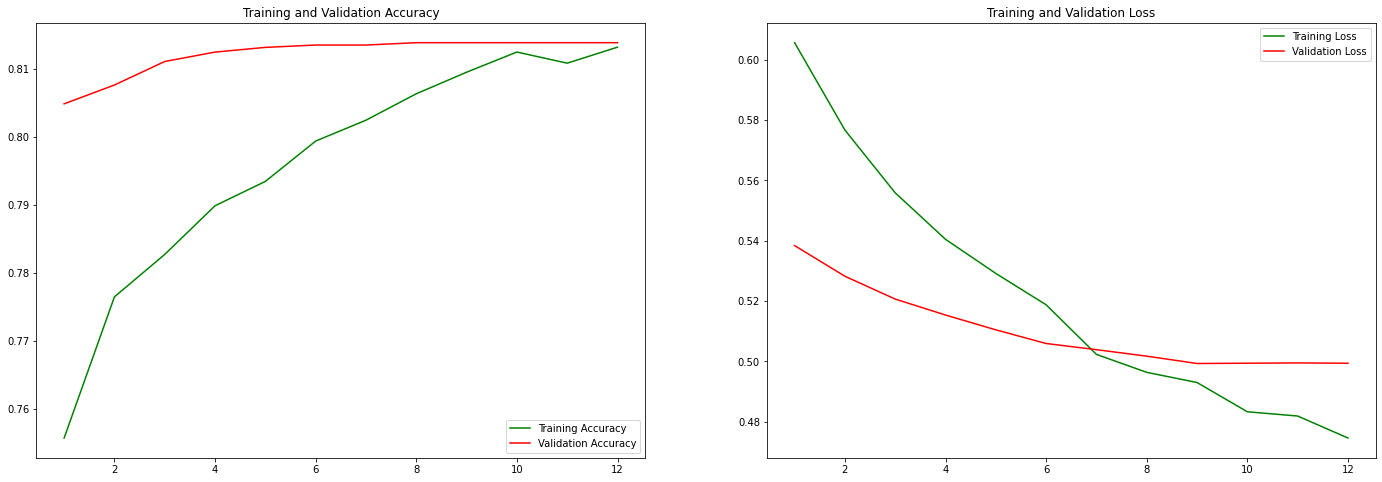

Validation Binary Accuracy is: 0.81
36/36 [==============================] - 2s 50ms/step - loss: 0.4991 - binary_accuracy: 0.8100
Testing Binary Accuracy is: 0.81


In [42]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_data_gen, 
                         test_data_gen,
                         'models/evaluate/model_4_evaluation.pdf')